In [2]:
import numpy as np
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import pdspy.modeling as modeling
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.animation import FuncAnimation
import os
import pickle

%matplotlib inline

### read in data

In [7]:
param_names = ["T_star","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]

ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
steps=[]
bases=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))
    bases.append(steps[i][5])

# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)[100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]

# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

### implement PCA on full grid

In [37]:
# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

done in 0.042s


### read in slice data

In [78]:
# slices - read in filenames and logspace flux values
with open ('../grid_metadata/slicenames.txt', 'rb') as fp:
    slicenames = pickle.load(fp)
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    slicevals = pickle.load(fp)[:,:,100:500]
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    nanslicevals = pickle.load(fp)[:,:,100:500]

In [59]:
#import os
#gammadir='./../grid/transform/gamma/'
#logmenvdir='./../grid/transform/logmenv/'
#gammas=[]
#gammaseds=[]
#for i in range(len(os.listdir(gammadir))):
#    gammas.append(float(os.listdir(gammadir)[i].split("_")[(2*6)+1]))
#    filename=os.listdir(gammadir)[i]
#    model=modeling.YSOModel()
#    model.read_yso(gammadir+filename)
#    gammaseds.append(np.log10(model.spectra["SED"].flux)[100:500])
#
#logmenvs=[]
#logmenvseds=[]
#for i in range(len(os.listdir(logmenvdir))):
#    logmenvs.append(float(os.listdir(logmenvdir)[i].split("_")[(2*8)+1]))
#    filename=os.listdir(logmenvdir)[i]
#    model=modeling.YSOModel()
#    model.read_yso(logmenvdir+filename)
#    logmenvseds.append(np.log10(model.spectra["SED"].flux)[100:500])

/users/eteng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


In [67]:
#gammasliceseds=[]
#logmenvsliceseds=[]
#gammaslicecoords=[]
#logmenvslicecoords=[]
#for i in range(11):
#    gammasliceseds.append(slicevals[6][i])
#    gammaslicecoords.append(float(slicenames[6][i].split("_")[(2*6)+1]))
#    logmenvsliceseds.append(slicevals[8][i])
#    logmenvslicecoords.append(float(slicenames[8][i].split("_")[(2*8)+1]))
#for i in range(len(gammas)):
#    gammasliceseds.append(gammaseds[i])
#    gammaslicecoords.append(gammas[i])
#    
#for i in range(len(logmenvs)):
#    logmenvsliceseds.append(logmenvseds[i])
#    logmenvslicecoords.append(logmenvs[i])

In [69]:
#with open('../grid_metadata/gammaslicecoords.txt', 'wb') as fp:
#    pickle.dump(gammaslicecoords, fp)
#with open('../grid_metadata/gammasliceseds.txt', 'wb') as fp:
#    pickle.dump(gammasliceseds, fp)
#with open('../grid_metadata/logmenvslicecoords.txt', 'wb') as fp:
#    pickle.dump(logmenvslicecoords, fp)
#with open('../grid_metadata/logmenvsliceseds.txt', 'wb') as fp:
#    pickle.dump(logmenvsliceseds, fp)

In [71]:
with open('../grid_metadata/gammaslicecoords.txt', 'rb') as fp:
    gammaslicecoords= pickle.load(fp)
with open('../grid_metadata/gammasliceseds.txt', 'rb') as fp:
    gammasliceseds= pickle.load(fp)
with open('../grid_metadata/logmenvslicecoords.txt', 'rb') as fp:
    logmenvslicecoords= pickle.load(fp)
with open('../grid_metadata/logmenvsliceseds.txt', 'rb') as fp:
    logmenvsliceseds= pickle.load(fp)

In [76]:
slicevals1=[gammasliceseds,logmenvsliceseds]
slicecoords1=[gammaslicecoords,logmenvslicecoords]

In [77]:
# fix -infs: powerlaw cutoff
for i in range(len(slicevals)):
    for j in range(len(slicevals[i])):
        if -np.inf in slicevals[i][j]:
            a = slicevals[i][j].tolist()
            a.reverse()
            ind = len(a)-a.index(-np.inf)
            x1 = xvals[ind]
            y1 = slicevals[i][j][ind]
            for m in range(ind):
                slicevals[i][j][m]=(100*(np.log10(xvals[m]/x1)))+y1
                
nanslicevals[nanslicevals<-20]=np.nan

# subtracting from the seds each sample mean
slice_seds_msub = slicevals - np.nanmean(nanslicevals,axis=2)[:,:,np.newaxis]

### fit slices

In [8]:
fitdata=[]

for i in range(len(param_names)):
    fitdata.append([])

In [11]:
for i in range(len(param_names)):
    for j in range(11):
        modeldata=[]
        paramval=steps[i][j]
        coeffs=pca.transform(slice_seds_msub[i][j].reshape(1,-1))
        modeldata.append(paramval)
        for k in range(10):
            modeldata.append(coeffs[0][k])
        fitdata[i].append(modeldata)

### plot coefficient values against parameter values

In [32]:
def plotpcwpar_all(param):
    #pdf = PdfPages("../visualization/pcwpar/"+param_names[param]+"_pcwpar.pdf")
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(8,12))
    
    for coeffindex in range(10):
        pvals=[]
        cvals=[]
        for i in range(11):
            if not param in log:
                pvals.append(fitdata[param][i][0])
                
            else:
                if param==6:
                    pvals.append(np.log10(2.1-1*fitdata[param][i][0]))
                if param==8:
                    pvals.append(np.log10(-1.5-1*fitdata[param][i][0]))
                if param==14:
                    pvals.append(1-np.cos(fitdata[param][i][0]*np.pi/90))
            cvals.append(fitdata[param][i][coeffindex+1])         
        ax[coeffindex//2][coeffindex%2].scatter(pvals,cvals)
        ax[coeffindex//2][coeffindex%2].set_xlabel(param_names[param])
        ax[coeffindex//2][coeffindex%2].set_ylabel("w"+str(coeffindex))
    
    plt.subplots_adjust(hspace=0.6)
    plt.subplots_adjust(wspace=0.7)
    plt.show()
    
    # Now save the figure.
    #pdf.savefig(fig)
    plt.clf()

    # Close the pdf.
    #pdf.close()
    print("principal component weight/parameter plots generated for ", param_names[param])

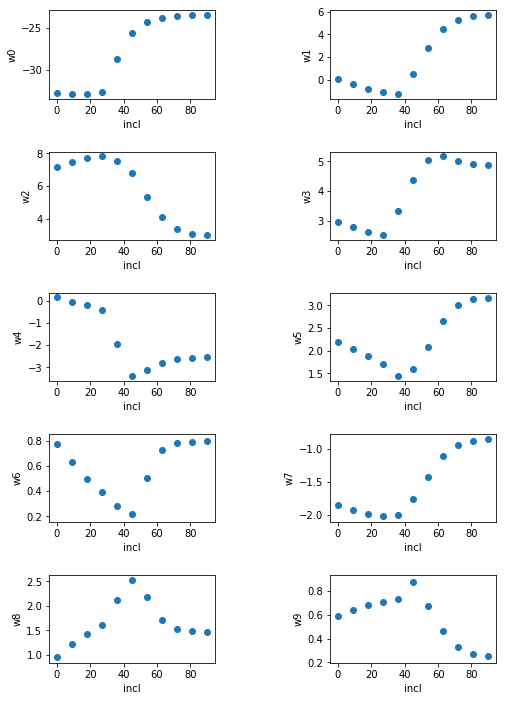

principal component weight/parameter plots generated for  incl


<Figure size 432x288 with 0 Axes>

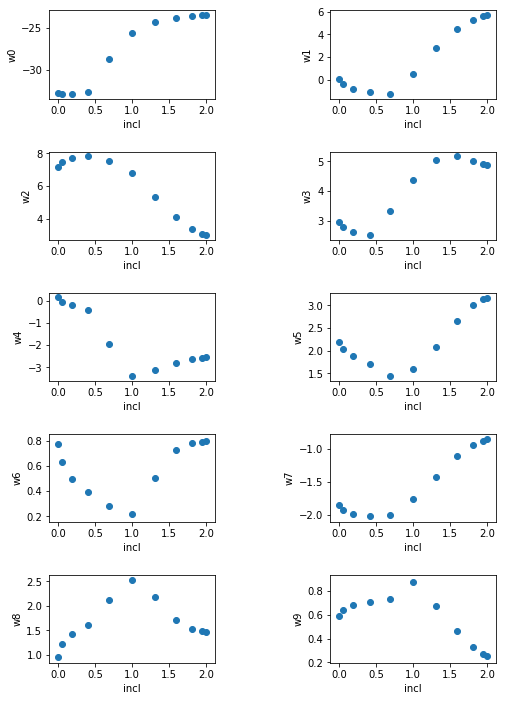

principal component weight/parameter plots generated for  incl


<Figure size 432x288 with 0 Axes>

In [33]:
log=[]
plotpcwpar_all(14)
log=[14]
plotpcwpar_all(14)

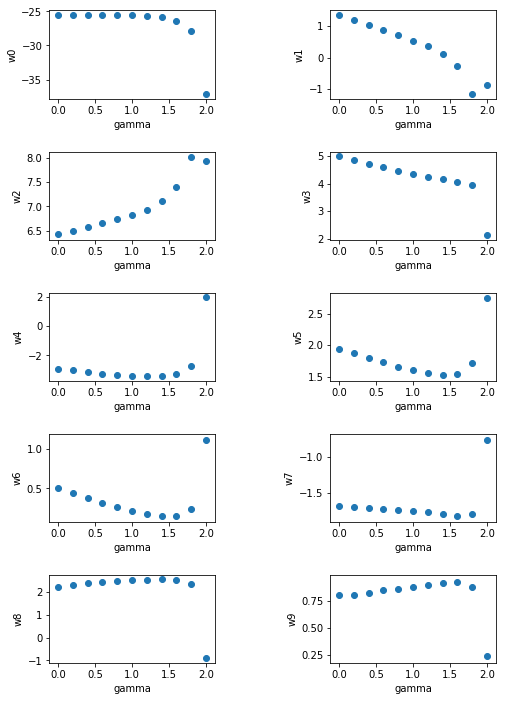

principal component weight/parameter plots generated for  gamma


<Figure size 432x288 with 0 Axes>

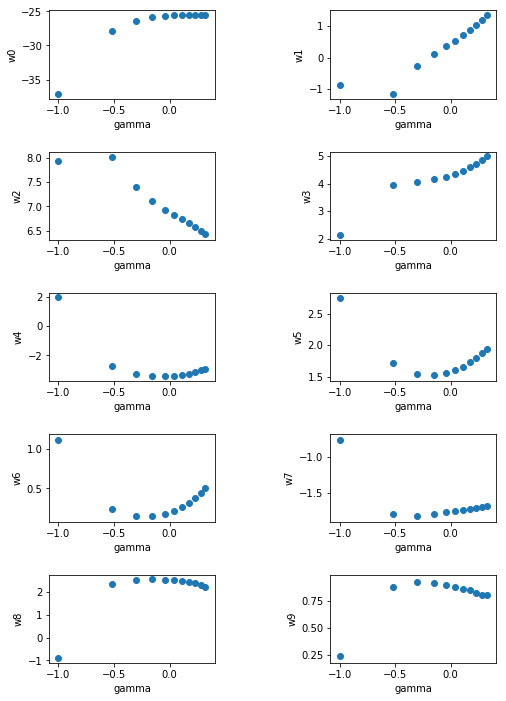

principal component weight/parameter plots generated for  gamma


<Figure size 432x288 with 0 Axes>

In [118]:
log=[]
plotpcwpar_all(6)
log=[6]
plotpcwpar_all(6)

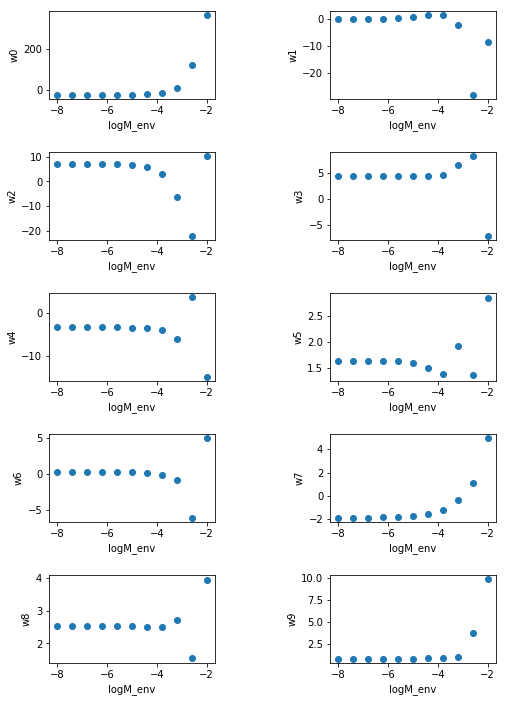

principal component weight/parameter plots generated for  logM_env


<Figure size 432x288 with 0 Axes>

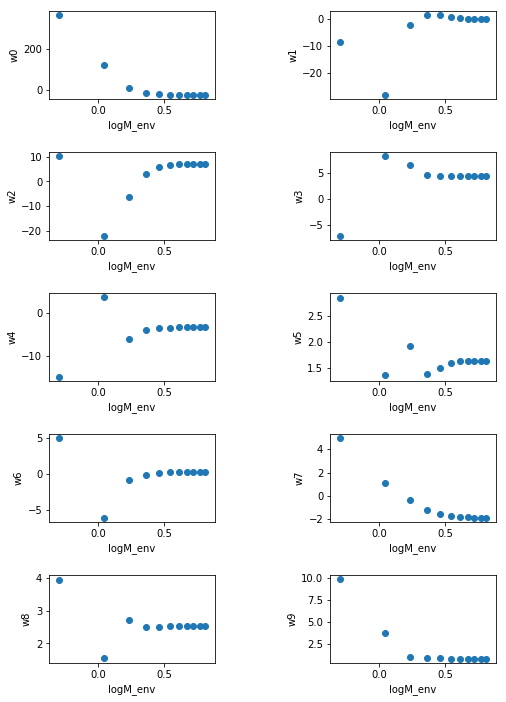

principal component weight/parameter plots generated for  logM_env


<Figure size 432x288 with 0 Axes>

In [120]:
log=[]
plotpcwpar_all(8)
log=[8]
plotpcwpar_all(8)

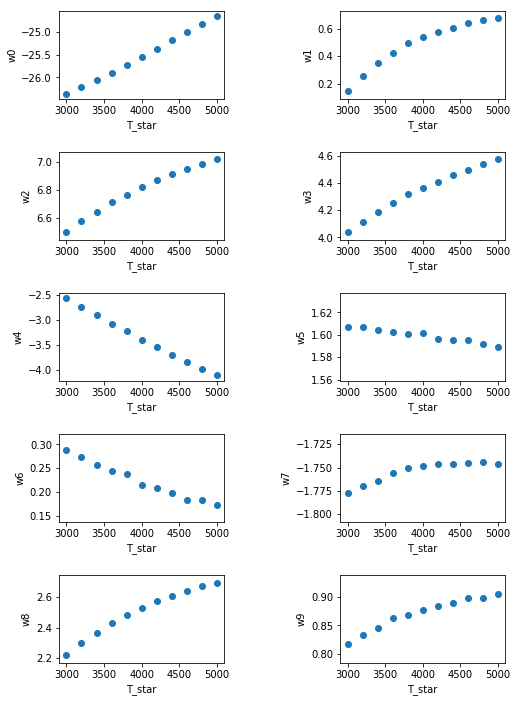

principal component weight/parameter plots generated for  T_star


<Figure size 432x288 with 0 Axes>

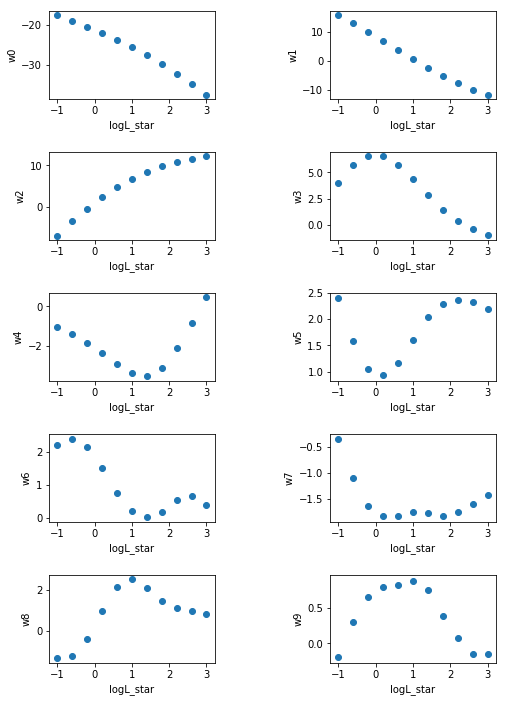

principal component weight/parameter plots generated for  logL_star


<Figure size 432x288 with 0 Axes>

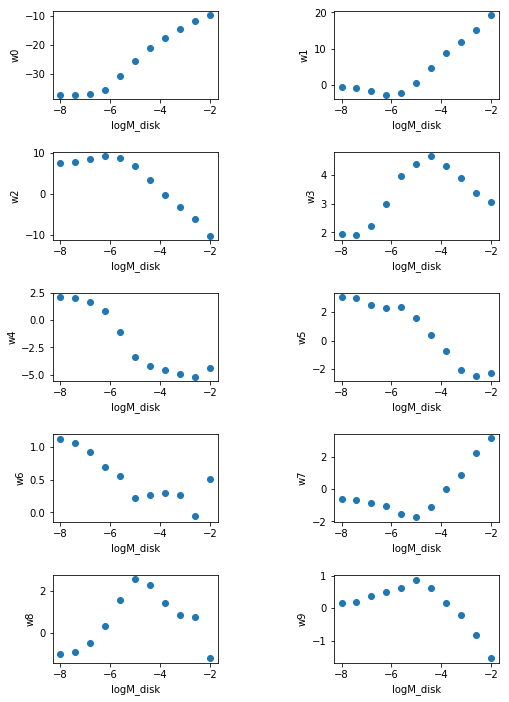

principal component weight/parameter plots generated for  logM_disk


<Figure size 432x288 with 0 Axes>

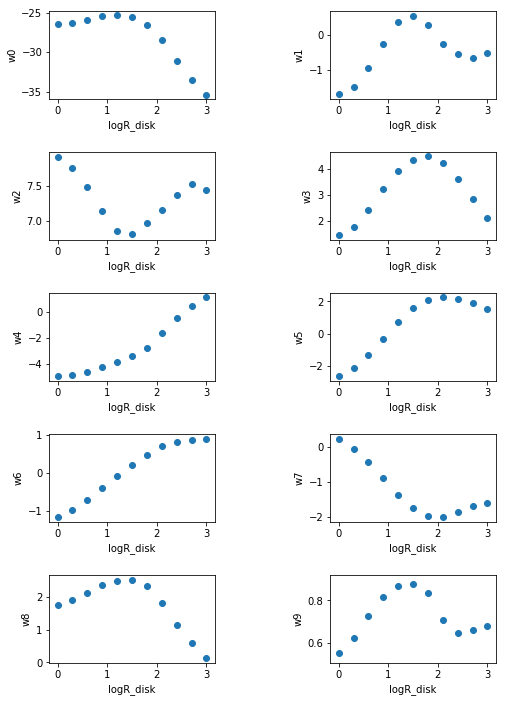

principal component weight/parameter plots generated for  logR_disk


<Figure size 432x288 with 0 Axes>

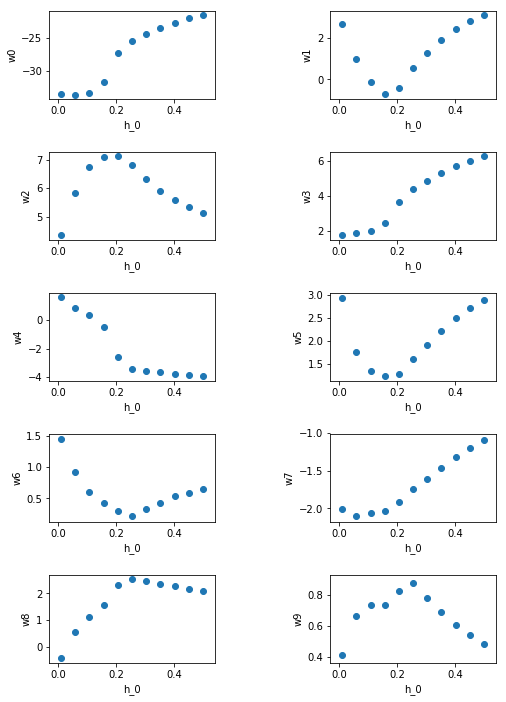

principal component weight/parameter plots generated for  h_0


<Figure size 432x288 with 0 Axes>

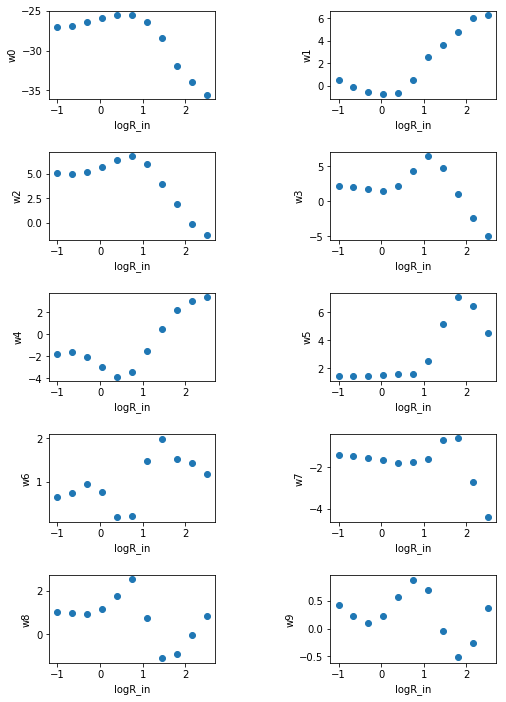

principal component weight/parameter plots generated for  logR_in


<Figure size 432x288 with 0 Axes>

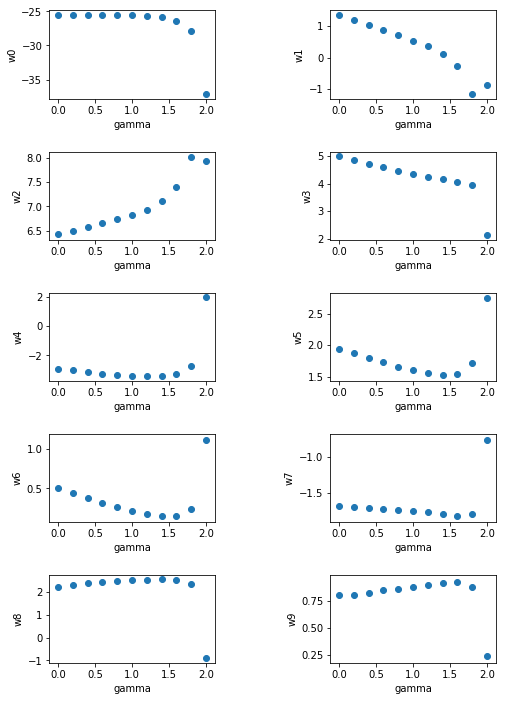

principal component weight/parameter plots generated for  gamma


<Figure size 432x288 with 0 Axes>

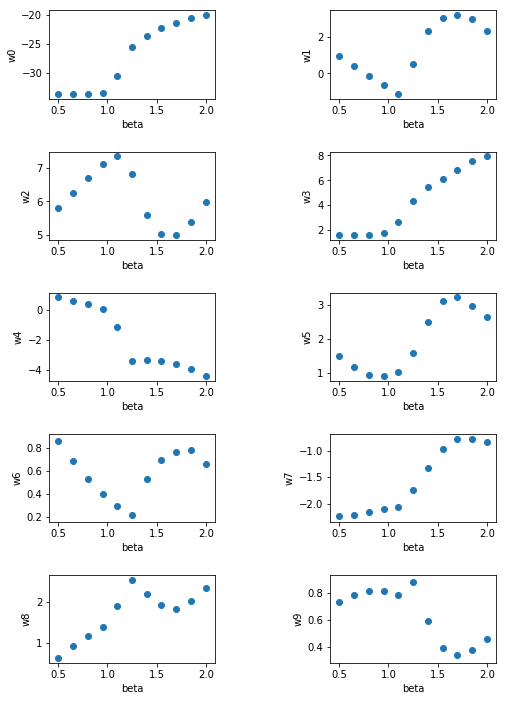

principal component weight/parameter plots generated for  beta


<Figure size 432x288 with 0 Axes>

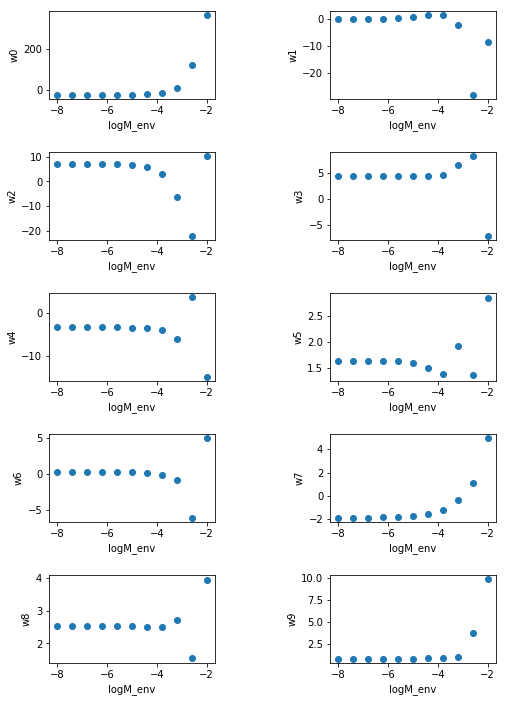

principal component weight/parameter plots generated for  logM_env


<Figure size 432x288 with 0 Axes>

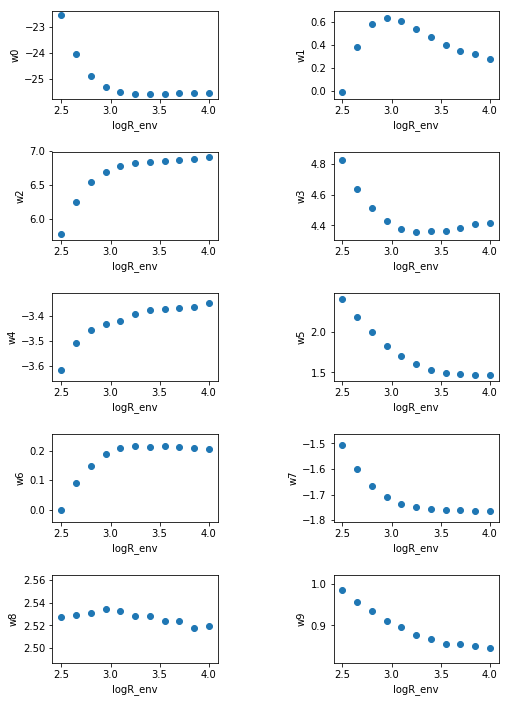

principal component weight/parameter plots generated for  logR_env


<Figure size 432x288 with 0 Axes>

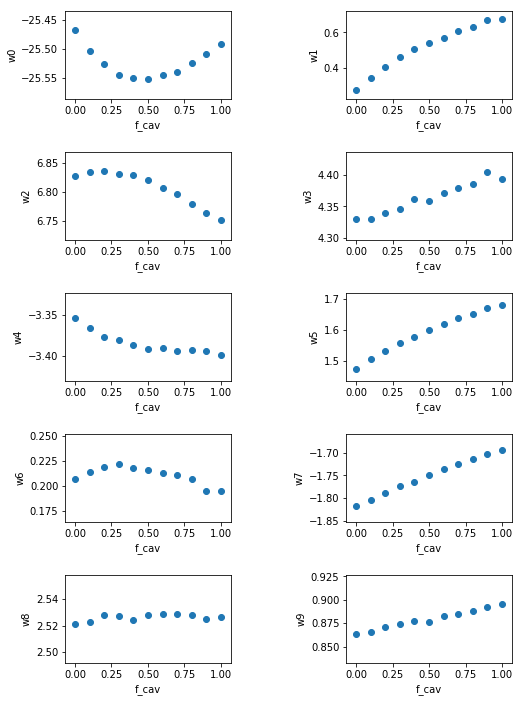

principal component weight/parameter plots generated for  f_cav


<Figure size 432x288 with 0 Axes>

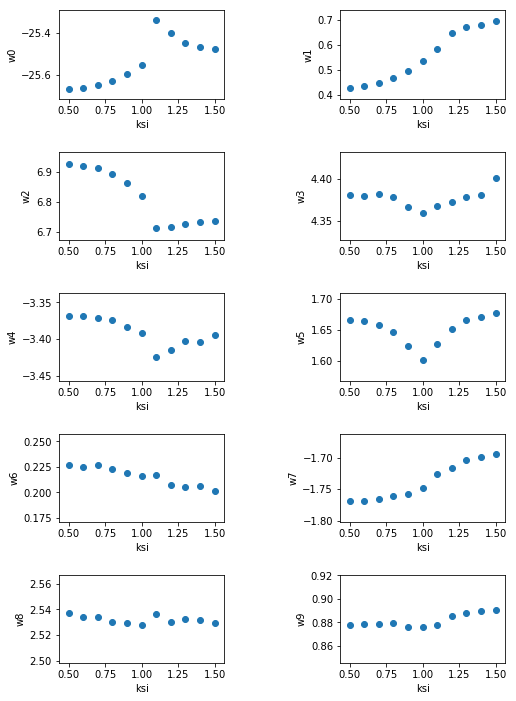

principal component weight/parameter plots generated for  ksi


<Figure size 432x288 with 0 Axes>

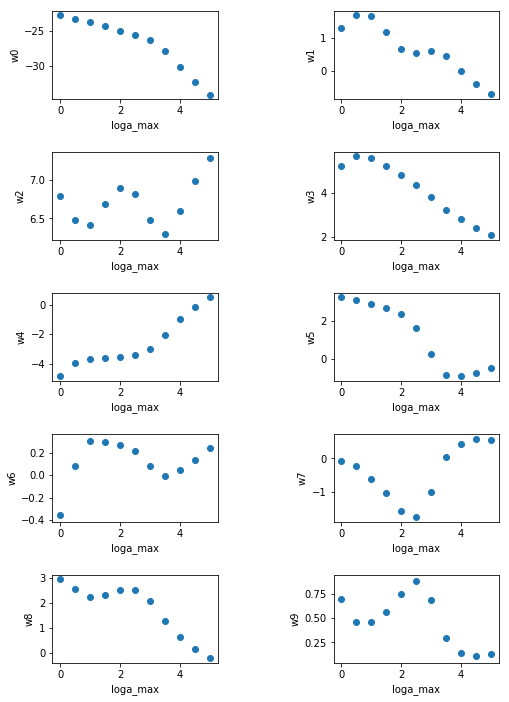

principal component weight/parameter plots generated for  loga_max


<Figure size 432x288 with 0 Axes>

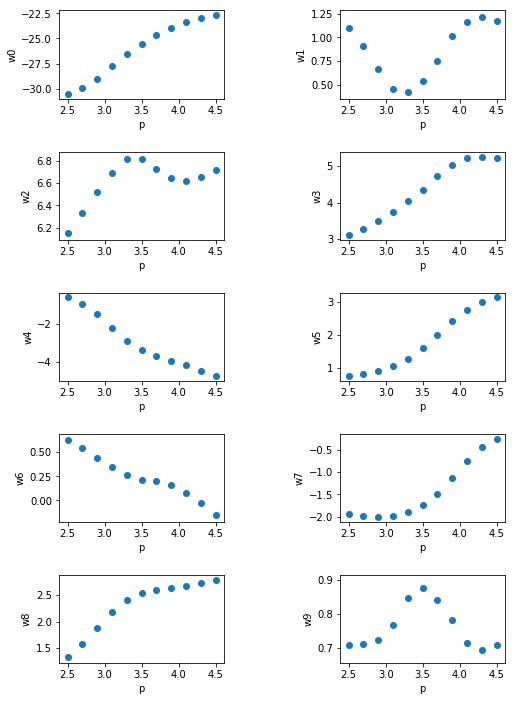

principal component weight/parameter plots generated for  p


<Figure size 432x288 with 0 Axes>

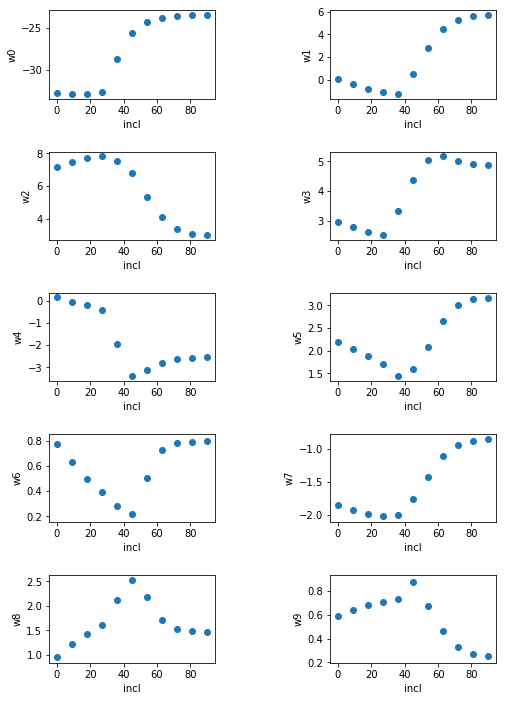

principal component weight/parameter plots generated for  incl


<Figure size 432x288 with 0 Axes>

In [17]:
log=[]
for i in range(len(param_names)):
    plotpcwpar_all(i)

### visualizing model fitting

In [ ]:
def sedcomp(param,model,ncomp=10, nfeat=500):
    fig,ax=plt.subplots(1,figsize=(12,9))
    coeffs=pca.transform(slice_seds_msub[param][model].reshape(1,-1))
    reconst=np.dot(coeffs[0][0:ncomp],eigenseds[0:ncomp,0:nfeat]) \
            +pca.mean_[0:nfeat]+np.nanmean(nanslicevals[param][model])    
    ax.plot(np.log10(xvals)[0:nfeat], reconst, c='b',label="reconstructed SED, ncomp="+str(ncomp))
    ax.plot(np.log10(xvals)[0:nfeat], slicevals[param][model][0:nfeat], c='black',label="pdspy SED")
    plt.legend()
    plt.title("reconstructed SED of "+param_names[param]+"="+str(steps[param][model])+" model against pdspy SED")
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

In [ ]:
for m in range(10):
    sedcomp(8,8,ncomp=m)

In [ ]:
for i in range(11):
    print(i)
    plt.plot(slicevals[1][i])
    plt.show()

In [ ]:
def residcomp(param,model,ncomp=10,nfeat=500):
    
    interval=np.linspace(0.1,1.,ncomp)
    colors= plt.cm.viridis(interval)
    
    fig,ax=plt.subplots(1,figsize=(12,9))
    
    for m in range(ncomp):
        coeffs=pca.transform(slice_seds_msub[param][model].reshape(1,-1))
        reconst=np.dot(coeffs[0][0:m],eigenseds[0:m,0:nfeat]) \
                    +pca.mean_[0:nfeat]+np.nanmean(nanslicevals[param][model])    
        resids = reconst-(slicevals[param][model][0:nfeat]) # log flux space residuals
        ax.plot(np.log10(xvals)[0:nfeat],resids, c=colors[m],label="ncomp="+str(m+1)) 
    plt.legend()
    plt.title("log-space residuals of reconst. SEDs of "+param_names[param]+"="+str(steps[param][model])+" model, by number of components")
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

In [ ]:
residcomp(8,4)

In [ ]:
def sedcomp(param,model,ncomp=10, nfeat=500):
    fig,ax=plt.subplots(1,figsize=(12,9))
    coeffs=pca.transform(slice_seds_msub[param][model].reshape(1,-1))
    reconst=np.dot(coeffs[0][0:ncomp],eigenseds[0:ncomp,0:nfeat]) \
            +pca.mean_[0:nfeat]+np.nanmean(nanslicevals[param][model])    
    ax.plot(np.log10(xvals)[0:nfeat], reconst, c='b',label="reconstructed SED, ncomp="+str(ncomp))
    ax.plot(np.log10(xvals)[0:nfeat], slicevals[param][model][0:nfeat], c='black',label="pdspy SED")
    plt.legend()
    plt.title("reconstructed SED of "+param_names[param]+"="+str(steps[param][model])+" model against pdspy SED")
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

In [ ]:
for m in range(1,11):
    sedcomp(8,8,ncomp=m)

In [ ]:
for m in range(11):
    sedcomp(8,m,ncomp=16)

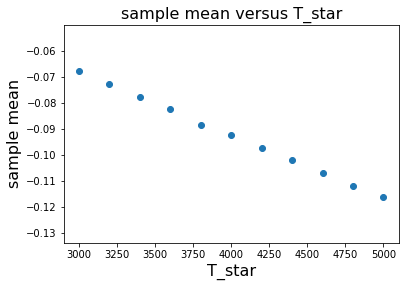

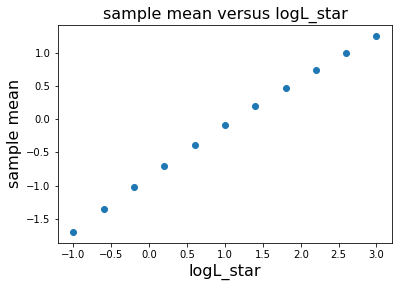

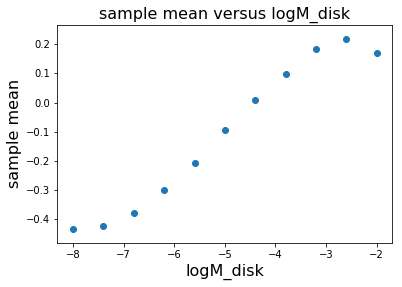

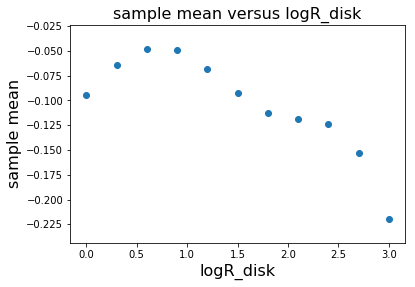

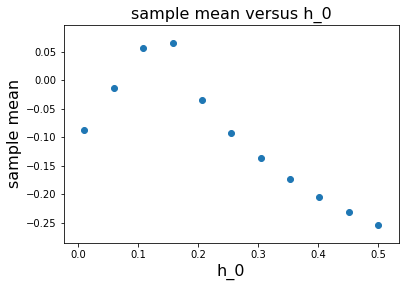

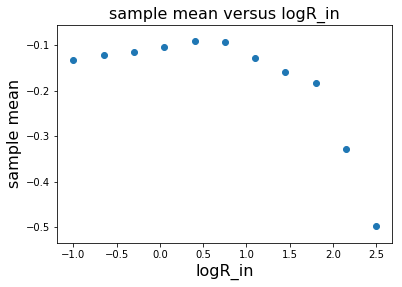

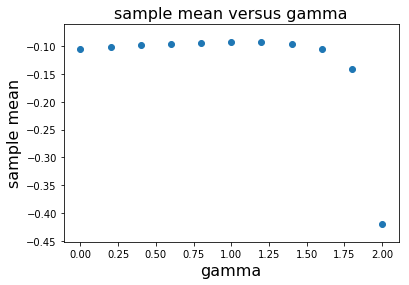

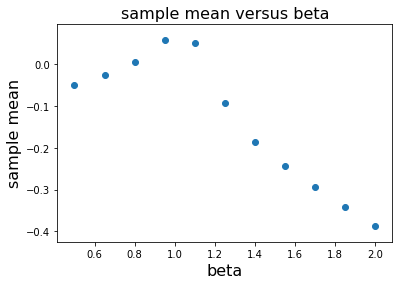

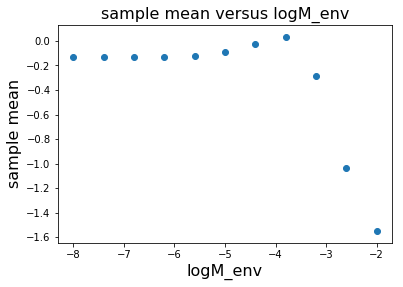

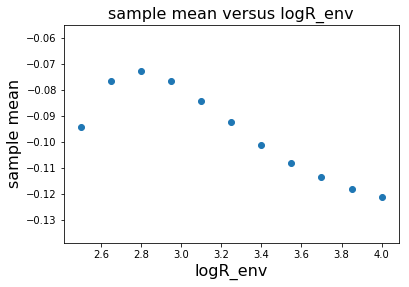

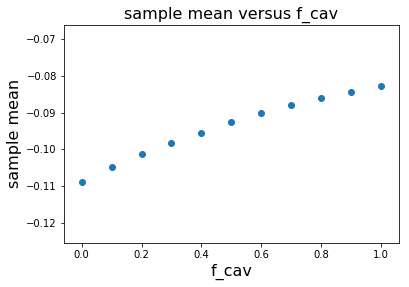

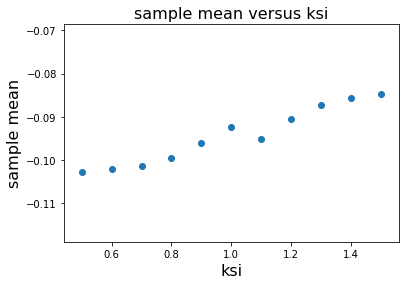

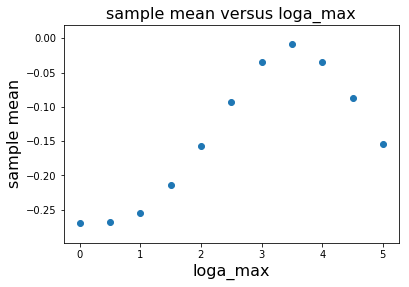

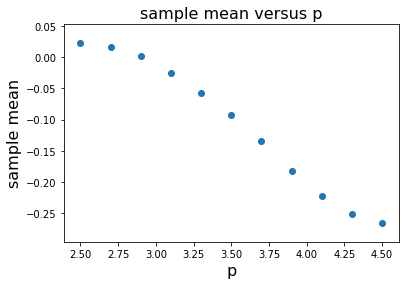

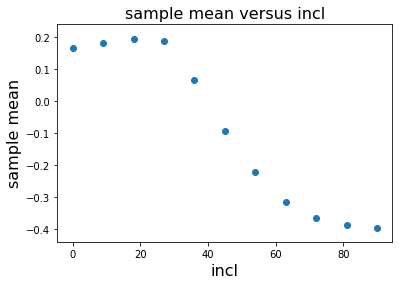

In [29]:
for param in range(15):
    fig,ax=plt.subplots(1)
    pvals=[]
    mvals=[]
    for i in range(11):
        pvals.append(fitdata[param][i][0])
        mvals.append(np.nanmean(nanslicevals,axis=2)[param][i])
    ax.scatter(pvals,mvals)
    plt.title("sample mean versus "+param_names[param],fontsize=16)
    plt.ylabel("sample mean",fontsize=16)
    plt.xlabel(param_names[param],fontsize=16)
    plt.show()    

In [26]:
np.array(np.nanmean(nanslicevals,axis=2)).shape

(15, 11)

In [25]:
np.nanmean(nanslicevals,axis=2)

array([[-6.78301230e-02, -7.29045123e-02, -7.78836831e-02,
        -8.25311244e-02, -8.83628875e-02, -9.24428552e-02,
        -9.75173935e-02, -1.02117307e-01, -1.07026748e-01,
        -1.11768380e-01, -1.16014749e-01],
       [-1.69763720e+00, -1.35319471e+00, -1.02123523e+00,
        -7.00882852e-01, -3.91070396e-01, -9.24428552e-02,
         1.96045265e-01,  4.73889261e-01,  7.41925359e-01,
         1.00074744e+00,  1.25369000e+00],
       [-4.32529002e-01, -4.24457163e-01, -3.78720552e-01,
        -2.99282312e-01, -2.07362592e-01, -9.24428552e-02,
         8.60092137e-03,  9.95709226e-02,  1.83712304e-01,
         2.17858538e-01,  1.69930592e-01],
       [-9.42211151e-02, -6.41859025e-02, -4.77502458e-02,
        -4.95066829e-02, -6.82333410e-02, -9.24428552e-02,
        -1.12708397e-01, -1.18824348e-01, -1.23606719e-01,
        -1.53133541e-01, -2.19621539e-01],
       [-8.77930075e-02, -1.27868271e-02,  5.64687364e-02,
         6.57255948e-02, -3.39466110e-02, -9.24428552e-02,
  